# Spaceship Base Model

## Import and concat the data

In [1]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
submission_data = pd.read_csv('data/sample_submission.csv')

train_y = train_data['Transported']
train_x = train_data.drop(columns='Transported')

test_y = submission_data['Transported']
test_x = test_data

x_data = pd.concat([train_x, test_x], axis=0, ignore_index=True)
y_data = pd.concat([train_y, test_y], axis=0, ignore_index=True)

df = pd.concat([x_data, y_data], axis=1)

df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,False
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,False
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,False
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,False


In [3]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   12970 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 1.3+ MB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   12970 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 1.3+ MB


## Exploratory Data Analysis (EDA)

### Visualizing Target Variable

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/1706361685.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Transported', palette='viridis')


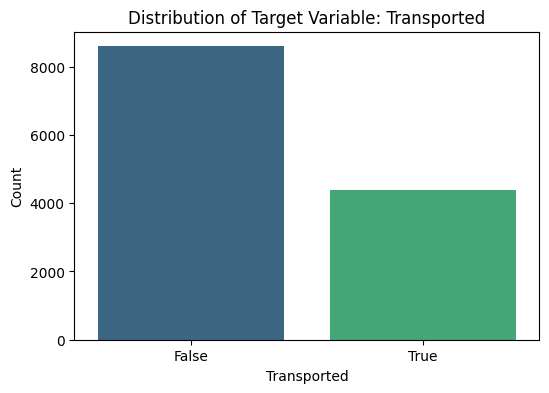

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Transported', palette='viridis')
plt.title('Distribution of Target Variable: Transported')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

### Missing Values Analysis

Missing Values:
 PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
dtype: int64


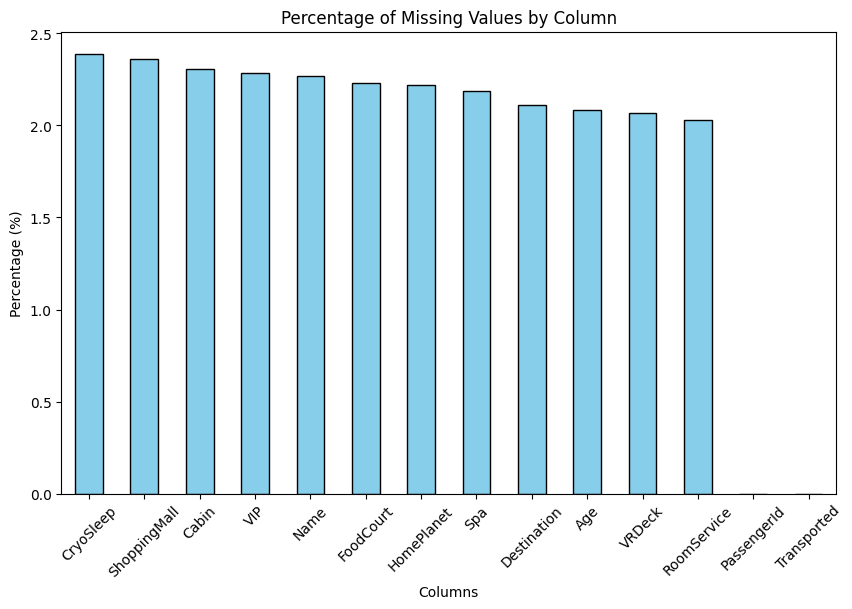

In [8]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

missing_percent = (df.isnull().sum() / len(df)) * 100
plt.figure(figsize=(10, 6))
missing_percent.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

### Numerical Features Analysis

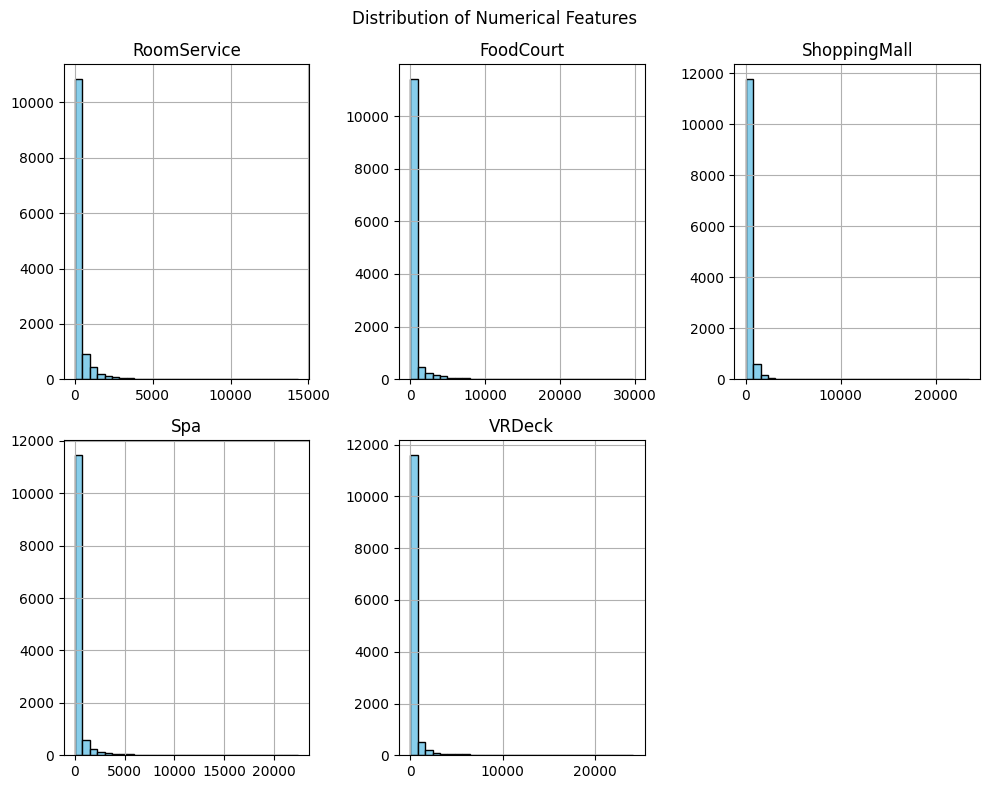

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/2202071602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='coolwarm')
/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/2202071602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='coolwarm')
/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/2202071602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=feature, palette='coolwarm')
/var/folders/mz/90j2mwc116g4xxfj2_10f8b0000

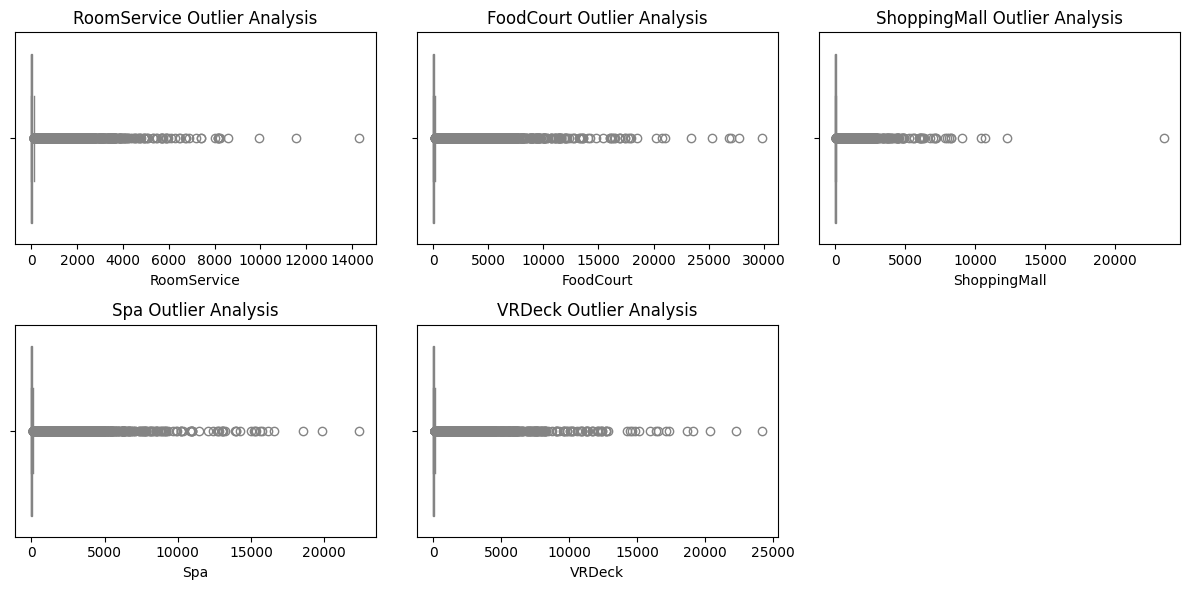

In [9]:
numerical_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df[numerical_features].hist(bins=30, figsize=(10, 8), layout=(2, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=feature, palette='coolwarm')
    plt.title(f'{feature} Outlier Analysis')
plt.tight_layout()
plt.show()

### Categorical Features Analysis

Unique values in HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Unique values in Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Unique values in VIP: [False True nan]


/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/33823324.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis', order=df[feature].value_counts().index)
/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/33823324.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='viridis', order=df[feature].value_counts().index)
/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/33823324.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=

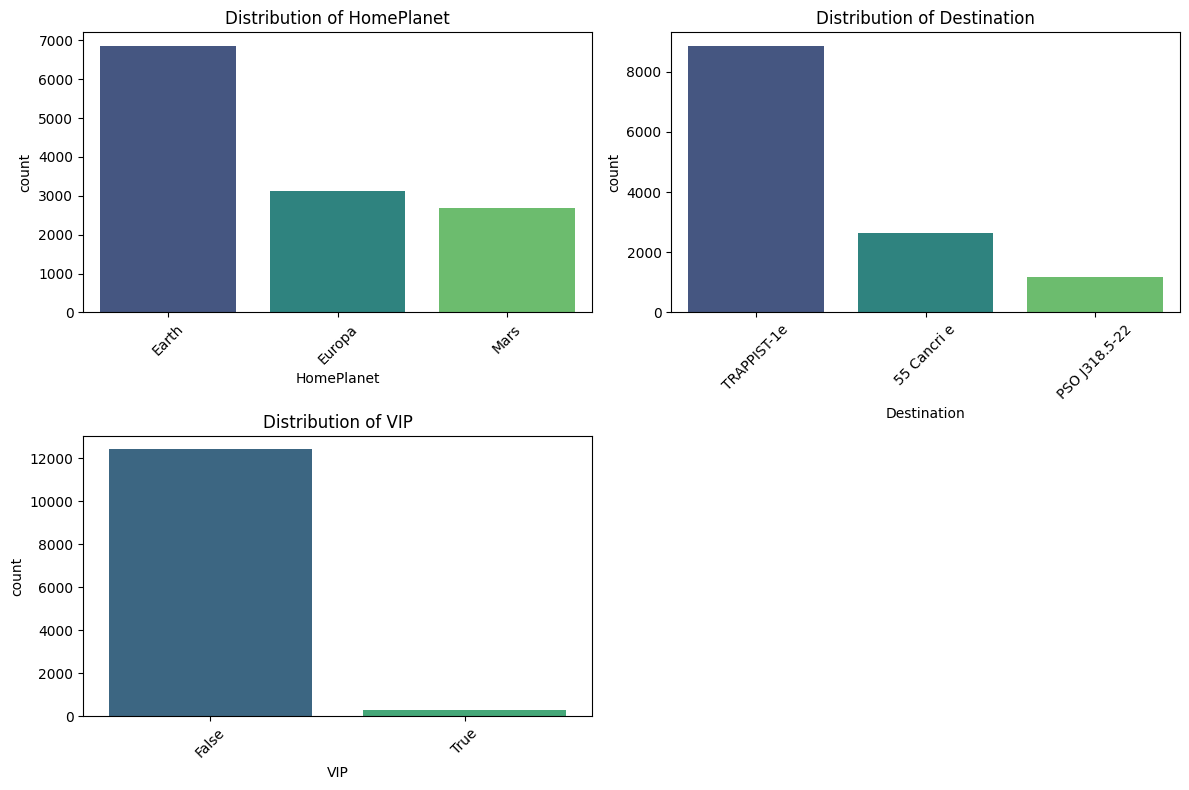

In [10]:
# in case of "Cabin" we can't understand from the graph
categorical_features = ['HomePlanet', 'Destination', 'VIP']

for feature in categorical_features:
    print(f"Unique values in {feature}: {df[feature].unique()}")

plt.figure(figsize=(12, 8))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, palette='viridis', order=df[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Relationship Analysis

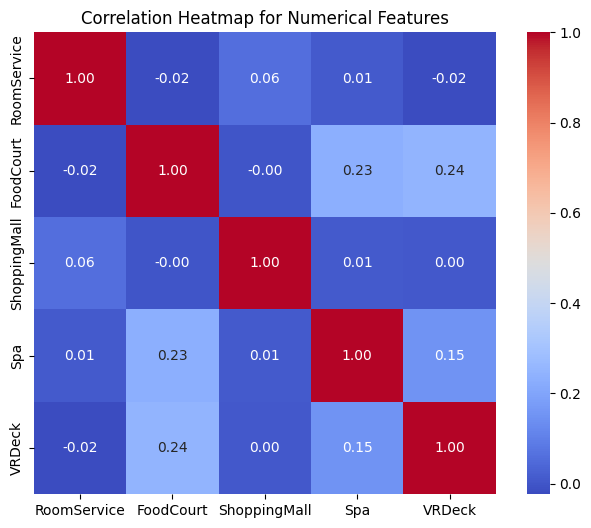

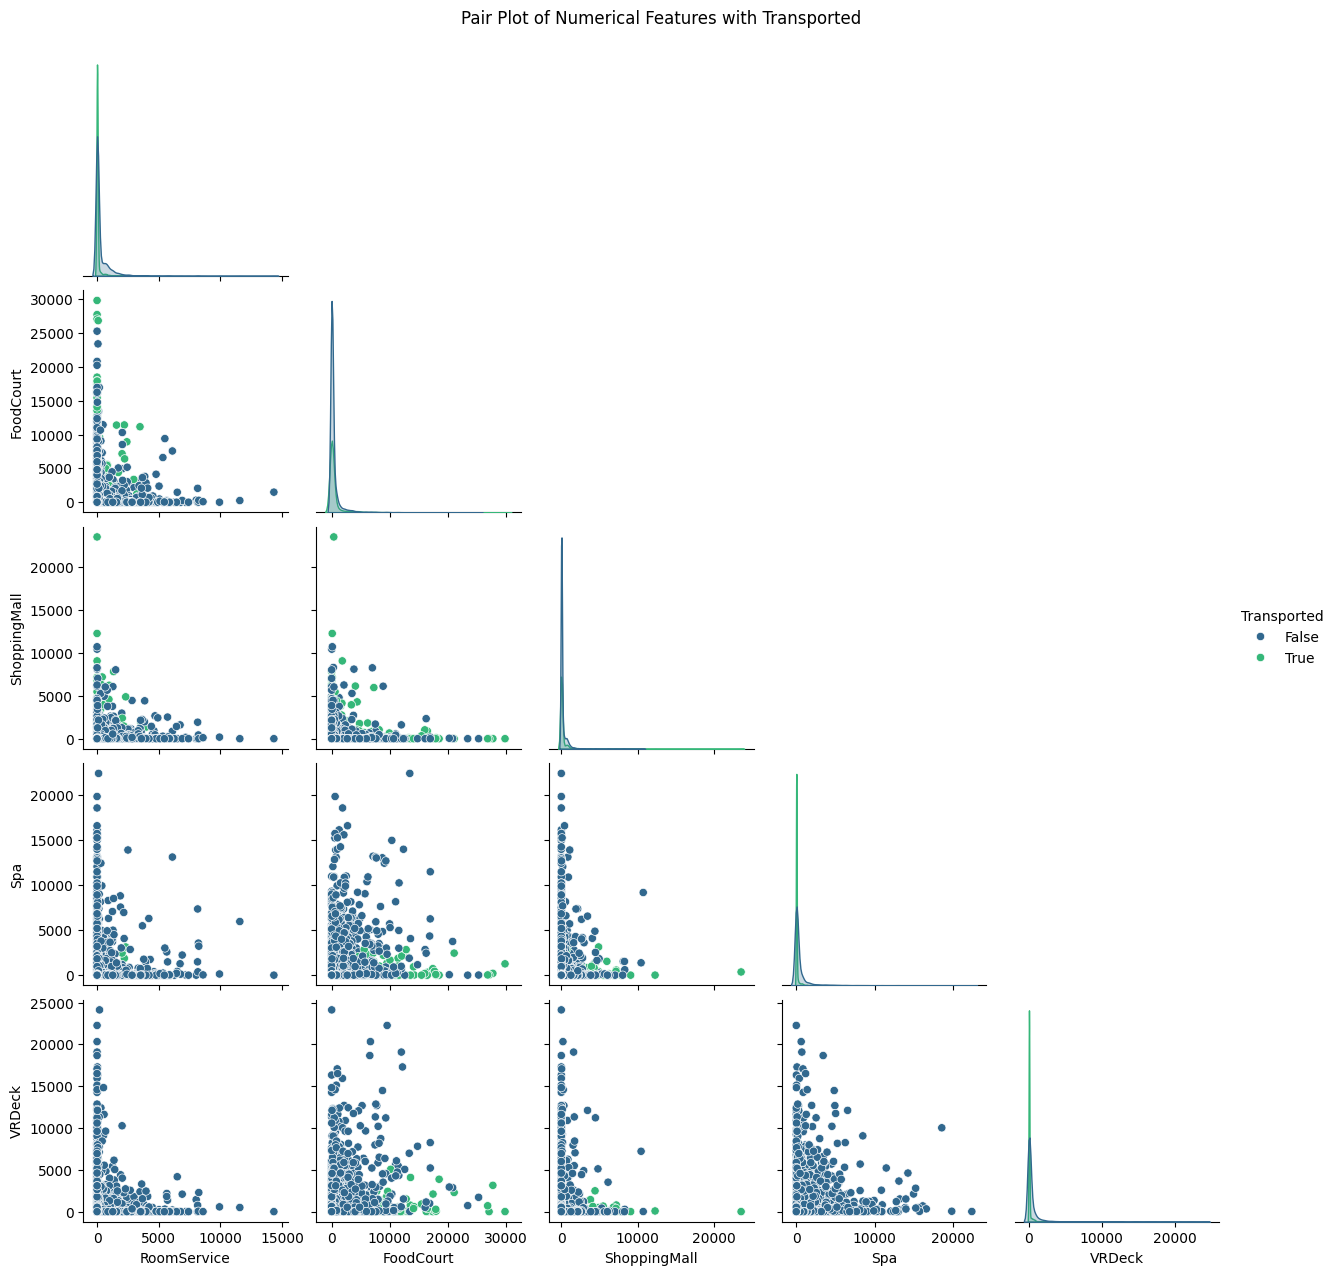

In [11]:
numerical_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=True)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

sns.pairplot(df, vars=numerical_features, hue='Transported', palette='viridis', diag_kind='kde', corner=True)
plt.suptitle('Pair Plot of Numerical Features with Transported', y=1.02)
plt.show()

### Feature Interaction

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/351489096.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='CryoSleep', y='RoomService', palette='viridis')


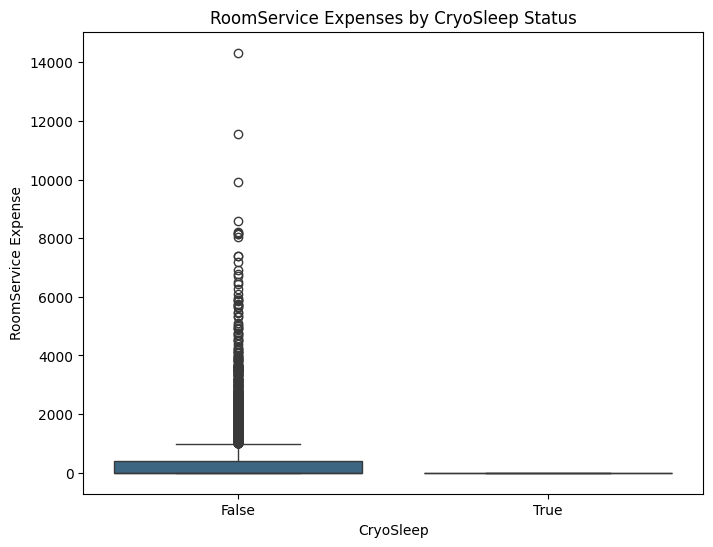

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/351489096.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='CryoSleep', y='TotalExpenses', palette='coolwarm')


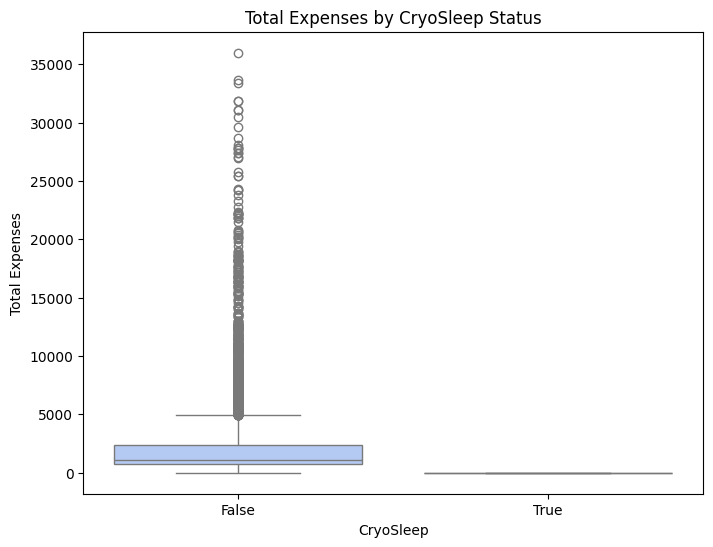

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='CryoSleep', y='RoomService', palette='viridis')
plt.title('RoomService Expenses by CryoSleep Status')
plt.xlabel('CryoSleep')
plt.ylabel('RoomService Expense')
plt.show()

df['TotalExpenses'] = df[numerical_features].sum(axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='CryoSleep', y='TotalExpenses', palette='coolwarm')
plt.title('Total Expenses by CryoSleep Status')
plt.xlabel('CryoSleep')
plt.ylabel('Total Expenses')
plt.show()

## Data Preprocessing

### Numerical Columns: Impute with median values

In [13]:
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for feature in numerical_features:
    median_value = df[feature].median()
    df[feature].fillna(median_value, inplace=True)

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/2251782974.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(median_value, inplace=True)
/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/2251782974.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

### Categorical Columns: Impute with mode

In [14]:
categorical_features = ['HomePlanet', 'Destination', 'Cabin']
for feature in categorical_features:
    mode_value = df[feature].mode()[0]
    df[feature].fillna(mode_value, inplace=True)

# For 'VIP' column, fill missing values with 'False' assuming non-VIP status
df['VIP'].fillna(False, inplace=True)

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/1377885678.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(mode_value, inplace=True)
/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/1377885678.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

### Feature Engineering

#### CryoSleep Column: Impute based on expense patterns

In [15]:
# Assuming passengers with zero expenses in all categories are likely in CryoSleep
expense_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['TotalExpenses'] = df[expense_features].sum(axis=1)

# If TotalExpenses is zero and CryoSleep is missing, assume CryoSleep=True
df.loc[(df['TotalExpenses'] == 0) & (df['CryoSleep'].isnull()), 'CryoSleep'] = True

# If TotalExpenses is greater than zero and CryoSleep is missing, assume CryoSleep=False
df.loc[(df['TotalExpenses'] > 0) & (df['CryoSleep'].isnull()), 'CryoSleep'] = False

# Drop the 'TotalExpenses' column as it's no longer needed
df.drop(columns=['TotalExpenses'], inplace=True)

#### Verify if all missing values are handled

In [16]:
missing_values = df.isnull().sum()
print("Missing Values after Imputation:\n", missing_values)

Missing Values after Imputation:
 PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            294
Transported       0
dtype: int64


In [17]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,False
12966,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,False
12967,9271_01,Mars,True,D/296/P,55 Cancri e,27.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,False
12968,9273_01,Europa,False,D/297/P,TRAPPIST-1e,27.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,False


#### Data Type Conversion

In [18]:
df = df.drop(columns=['Name'], axis=1)

# Split 'Cabin' into 'Deck', 'Num', and 'Side'
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

# Drop the original 'Cabin' column
df = df.drop('Cabin', axis=1)

conv_dict = {
    'HomePlanet': {'Europa': 0, 'Earth': 1, 'Mars': 2},
    'CryoSleep': {False: 0, True: 1},
    'Destination': {'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2},
    'VIP': {True: 1, False: 0},
    'Deck': {j: i for i, j in enumerate(sorted(df['Deck'].unique()))},
    'Side': {'P': 0, 'S': 1},
    'Transported': {False: 0, True: 1}
}

df = df.replace(conv_dict)

# Move the target to the end
df = df[[col for col in df if col != 'Transported'] + ['Transported']]

df

/var/folders/mz/90j2mwc116g4xxfj2_10f8b00000gn/T/ipykernel_1844/2859740490.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(conv_dict)


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,Transported
0,0001_01,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0002_01,1,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,5,0,1,1
2,0003_01,0,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0
3,0003_02,0,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0
4,0004_01,1,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,1,1,0,34.0,0,0.0,0.0,0.0,0.0,0.0,6,1496,1,0
12966,9269_01,1,0,0,42.0,0,0.0,847.0,17.0,10.0,144.0,6,160,0,0
12967,9271_01,2,1,1,27.0,0,0.0,0.0,0.0,0.0,0.0,3,296,0,0
12968,9273_01,0,0,0,27.0,0,0.0,2680.0,0.0,0.0,523.0,3,297,0,0


## Building the Base Model

### Check if the data is imbalanced

In [19]:
from collections import Counter

count = Counter(df['Transported'])
count

Counter({0: 8592, 1: 4378})

### Split Data into Train and Test Sets

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop('Transported', axis=1)
y = df['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# choosing the random state for the model
random_state = 42

### Train a Logistic Regression Model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lr_model = LogisticRegression(max_iter=5400, random_state=random_state)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7145526746087363
Logistic Regression Confusion Matrix:
 [[2448  391]
 [ 831  611]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80      2839
           1       0.61      0.42      0.50      1442

    accuracy                           0.71      4281
   macro avg       0.68      0.64      0.65      4281
weighted avg       0.70      0.71      0.70      4281



### Train a Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight="balanced", random_state=random_state)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7358093903293623
Random Forest Confusion Matrix:
 [[2447  392]
 [ 739  703]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      2839
           1       0.64      0.49      0.55      1442

    accuracy                           0.74      4281
   macro avg       0.71      0.67      0.68      4281
weighted avg       0.73      0.74      0.73      4281



### ROC and AUC Curves

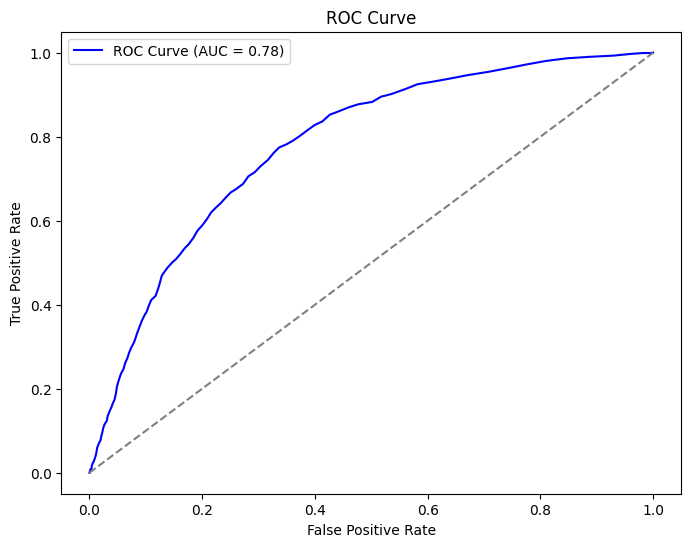

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### K-Fold Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='recall')

print(f"Cross-validated Recall scores: {cv_scores}")
print(f"Mean Recall: {cv_scores.mean():.4f}")

Cross-validated Recall scores: [0.00342857 0.         0.00570776 0.00114155 0.00342466]
Mean Recall: 0.0027


### Set a lower threshold to adjust Recall

In [31]:
from sklearn.metrics import recall_score

y_probs = rf_model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_probs >= 0.3).astype(int)

recall = recall_score(y_test, y_pred_adjusted)
print(f"Adjusted Recall: {recall:.4f}")

Adjusted Recall: 0.7621


### Handle Class Imbalance

In [33]:
import numpy as np
from imblearn.over_sampling import SMOTE

unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution before applying SMOTE:", dict(zip(unique, counts)))

smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_resampled, return_counts=True)
print("Class distribution after applying SMOTE:", dict(zip(unique, counts)))

Class distribution before applying SMOTE: {0: 5753, 1: 2936}
Class distribution after applying SMOTE: {0: 5753, 1: 5753}


### Train Random Forest Classifier after balancing the data

In [34]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=random_state)
rf_model.fit(X_resampled, y_resampled)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7222611539359962
Random Forest Confusion Matrix:
 [[2239  600]
 [ 589  853]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      2839
           1       0.59      0.59      0.59      1442

    accuracy                           0.72      4281
   macro avg       0.69      0.69      0.69      4281
weighted avg       0.72      0.72      0.72      4281



### Lower Decision Threshold

In [36]:
y_probs = rf_model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_probs >= 0.3).astype(int)
recall = recall_score(y_test, y_pred_adjusted)
print(f"Adjusted Recall: {recall:.4f}")

Adjusted Recall: 0.8336
